# Tutorial 1: Getting Started

## Overview
Welcome to FastEstimator! In this tutorial we are going to cover:
* Three main APIs of FastEstimator: `Pipeline`, `Network`, `Estimator`.
* Image classification example.

## Three main APIs
All deep learning training workﬂows involve the following three essential components, each represents a critical API in FastEstimator.

* **Data pipeline**: extracts data from disk/RAM, performs transformations. ->  `fe.Pipeline`


* **Network**: performs trainable and differentiable operations. ->  `fe.Network`


* **Training loop**: combines data pipeline and network in an iterative process. ->  `fe.Estimator`

<BR>
<BR>
Any deep learning task can be construsted by following the 3 main steps:
<img src="../resources/t01_api.png" alt="drawing" width="700"/>

## Image Classification Example

### Step 1 - Pipeline
We use FastEstimator dataset API to load the MNIST dataset. Please check out [tutorial 2](https://www.google.com) for more details about dataset API. The data preprocessing involves: 
1. Expand image dimension from (28,28) to (28, 28, 1) for convenience of convolution operation.
2. Rescale pixel value from [0, 255] to [0, 1].

Please check out [tutorial 3](link needed) for details about `Operator` and [tutorial 4](link needed) for `Pipeline`.

In [ ]:
import fastestimator as fe
from fastestimator.dataset.data import mnist
from fastestimator.op.numpyop.univariate import ExpandDims, Minmax

train_data, eval_data = mnist.load_data()

pipeline = fe.Pipeline(train_data=train_data,
                       eval_data=eval_data,
                       batch_size=32,
                       ops=[ExpandDims(inputs="x", outputs="x"), Minmax(inputs="x", outputs="x")])

### Step 2 - Network

The model definition can be either from `tf.keras.Model` or `torch.nn.Module`, for more info about network definition, check out [tutorial 5](link needed). The differentiable operations during training are listed as following:
1. Feed the preprocessed images to the network and get prediction scores.
2. Calculate `CrossEntropy` (loss) between prediction scores and ground truth.
3. Update the model by minimizing `CrossEntropy`.

For more info about `Network` and its operators, check out [tutorial 6](link needed).

In [2]:
from fastestimator.architecture.tensorflow import LeNet
# from fastestimator.architecture.pytorch import LeNet
# one can also use pytorch model

from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp

model = fe.build(model_fn=LeNet, optimizer_fn="adam")

network = fe.Network(ops=[
        ModelOp(model=model, inputs="x", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
        UpdateOp(model=model, loss_name="ce") 
    ])

### Step 3 - Estimator
we define the `Estimator` to connect the `Network` with `Pipeline` and compute accuracy as validation metrics. please go to [tutorial 7](link needed) for more about `Estimator` and `Traces`.

In [3]:
from fastestimator.trace.metric import Accuracy
from fastestimator.trace.io import BestModelSaver
import tempfile

traces = [Accuracy(true_key="y", pred_key="y_pred"),
          BestModelSaver(model=model, save_dir=tempfile.mkdtemp(), metric="accuracy", save_best_mode="max")]

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=2,
                         traces=traces)

### Start Training

In [ ]:
estimator.fit()

### Inferencing
After training, we can do inferencing on new data with `Pipeline.transform` and `Netowork.transform`. Please checkout [tutorial 8](link needed) for more details. 

Ground truth class is 7
Prediction class is 7


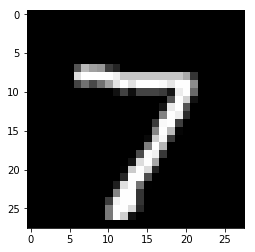

In [5]:
import matplotlib.pyplot as plt
import numpy as np

data = eval_data[0]
data = pipeline.transform(data, mode="eval")
data = network.transform(data, mode="eval")

plt.imshow(np.squeeze(data["x"]), cmap="gray")
print("Ground truth class is {}".format(data["y"][0]))
print("Prediction class is {}".format(np.argmax(data["y_pred"])))